# DSCI 573: Feature and Model Selection 

## Lecture 6: Feature Importances beyond Linear Models and Loss Functions

UBC Master of Data Science program, 2020-21

Instructor: Varada Kolhatkar 

### Learning outcomes 

From this lecture, students are expected to be able to: 

- Explain why interpretability is important in ML.
- Use `feature_importances_` attribute of `sklearn` models and interpret its output. 
- Use `eli5` to get feature importances of non `sklearn` models and interpret its output. 
- Apply SHAP to assess feature importances and interpret model predictions. 
- Explain force plot, summary plot, and dependence plot produced with shapely values.  
- Explain the general concept of loss functions. 
- Explain the implications of changing the loss function. 

In [1]:
import os

%matplotlib inline
import string
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# data
from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer

# Feature selection
from sklearn.feature_selection import RFE, RFECV
from sklearn.impute import SimpleImputer

# classifiers / models
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV

# other
from sklearn.metrics import accuracy_score, log_loss, make_scorer, mean_squared_error
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    ShuffleSplit,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PolynomialFeatures,
    StandardScaler,
)
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier

## 1.  Interpretability of ML models: Motivation

- video 1

### Why model interpretability? 

- Ability to interpret ML models is crucial in many applications such as banking, healthcare, and criminal justice.
- It can be leveraged by domain experts to diagnose systematic errors and underlying biases of complex ML systems. 

<img src="imgs/shap_example.png" width="600" height="600">

    
[Source](https://github.com/slundberg/shap/blob/master/docs/presentations/February%202018%20Talk.pptx)

### What is model interpretability? 

- In this course, our definition of model iterpretability will be looking at **feature importances**.
- There is more to interpretability than feature importances, but it's a good start!
- Resource: 
    - [Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/interpretability-importance.html)
    - [Yann LeCun, Kilian Weinberger, Patrice Simard, and Rich Caruana: Panel debate on interpretability](https://vimeo.com/252187813)

### Data

- Let's work with [the adult census data set](https://www.kaggle.com/uciml/adult-census-income) from last lecture. 

In [2]:
adult_df_large = pd.read_csv("data/adult.csv")
train_df, test_df = train_test_split(adult_df_large, test_size=0.2, random_state=42)
train_df_nan = train_df.replace("?", np.NaN)
test_df_nan = test_df.replace("?", np.NaN)
train_df_nan.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
5514,26,Private,256263,HS-grad,9,Never-married,Craft-repair,Not-in-family,White,Male,0,0,25,United-States,<=50K
19777,24,Private,170277,HS-grad,9,Never-married,Other-service,Not-in-family,White,Female,0,0,35,United-States,<=50K
10781,36,Private,75826,Bachelors,13,Divorced,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32240,22,State-gov,24395,Some-college,10,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,0,20,United-States,<=50K
9876,31,Local-gov,356689,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,<=50K


In [3]:
numeric_features = ["age", "fnlwgt", "capital.gain", "capital.loss", "hours.per.week"]
categorical_features = [
    "workclass",
    "marital.status",
    "occupation",
    "relationship",
    "native.country",
]
ordinal_features = ["education"]
binary_features = ["sex"]
drop_features = ["race", "education.num"]
target_column = "income"

In [4]:
education_levels = [
    "Preschool",
    "1st-4th",
    "5th-6th",
    "7th-8th",
    "9th",
    "10th",
    "11th",
    "12th",
    "HS-grad",
    "Prof-school",
    "Assoc-voc",
    "Assoc-acdm",
    "Some-college",
    "Bachelors",
    "Masters",
    "Doctorate",
]

In [5]:
assert set(education_levels) == set(train_df["education"].unique())

In [6]:
numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
tree_numeric_transformer = make_pipeline(SimpleImputer(strategy="median"))

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore"),
)

ordinal_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OrdinalEncoder(categories=[education_levels], dtype=int),
)

binary_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(drop="if_binary", dtype=int),
)

preprocessor = make_column_transformer(
    ("drop", drop_features),
    (numeric_transformer, numeric_features),
    (ordinal_transformer, ordinal_features),
    (binary_transformer, binary_features),
    (categorical_transformer, categorical_features),
)

In [7]:
X_train = train_df_nan.drop(columns=[target_column])
y_train = train_df_nan[target_column]

X_test = test_df_nan.drop(columns=[target_column])
y_test = test_df_nan[target_column]

### Do we have class imbalance? 

- There is class imbalance. But without any context, both classes seem equally important. 
- Let's use accuracy as our metric. 

In [8]:
train_df_nan["income"].value_counts(normalize=True)

<=50K    0.757985
>50K     0.242015
Name: income, dtype: float64

In [9]:
scoring_metric = "accuracy"

Let's store all the results in a dictionary called `results`. 

In [10]:
results = {}

In [11]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation.
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [12]:
scoring_metric = "accuracy"

In [13]:
from lightgbm.sklearn import LGBMClassifier
from xgboost import XGBClassifier

pipe_lr = make_pipeline(
    preprocessor, LogisticRegression(max_iter=2000, random_state=123)
)
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(random_state=123))
pipe_xgb = make_pipeline(preprocessor, XGBClassifier(random_state=123))
pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(random_state=123))
classifiers = {
    "logistic regression": pipe_lr,
    "random forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
}

In [14]:
dummy = DummyClassifier(strategy="stratified")
results["Dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

In [15]:
for (name, model) in classifiers.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring=scoring_metric
    )

In [16]:
pd.DataFrame(results)

,Dummy,logistic regression,random forest,XGBoost,LightGBM
fit_time,0.007 (+/- 0.001),0.750 (+/- 0.029),6.977 (+/- 0.062),0.460 (+/- 0.014),0.181 (+/- 0.036)
score_time,0.005 (+/- 0.000),0.019 (+/- 0.001),0.096 (+/- 0.003),0.041 (+/- 0.001),0.026 (+/- 0.000)
test_score,0.634 (+/- 0.005),0.850 (+/- 0.006),0.857 (+/- 0.004),0.871 (+/- 0.004),0.871 (+/- 0.004)
train_score,0.632 (+/- 0.002),0.851 (+/- 0.001),1.000 (+/- 0.000),0.908 (+/- 0.001),0.892 (+/- 0.000)


- One problem is that often simple models are interpretable but not accurate.
- But more complex models (e.g., LightGBM) are less interpretable.

<center>
<img src="imgs/shap_motivation.png" width="600" height="600">
</center>    

[Source](https://github.com/slundberg/shap/blob/master/docs/presentations/February%202018%20Talk.pptx)

### Feature importances in linear models

- Simpler models are often more interpretable but less accurate. 

Let's create and fit a pipeline with preprocessor and logistic regression. 

In [17]:
pipe_lr = make_pipeline(preprocessor, LogisticRegression(max_iter=2000, random_state=2))
pipe_lr.fit(X_train, y_train);

In [18]:
ohe_feature_names = (
    pipe_rf.named_steps["columntransformer"]
    .named_transformers_["pipeline-4"]
    .named_steps["onehotencoder"]
    .get_feature_names()
    .tolist()
)
feature_names = (
    numeric_features + ordinal_features + binary_features + ohe_feature_names
)
feature_names[:10]

['age',
 'fnlwgt',
 'capital.gain',
 'capital.loss',
 'hours.per.week',
 'education',
 'sex',
 'x0_Federal-gov',
 'x0_Local-gov',
 'x0_Never-worked']

In [19]:
data = {
    "coefficient": pipe_lr.named_steps["logisticregression"].coef_[0].tolist(),
    "magnitude": np.absolute(
        pipe_lr.named_steps["logisticregression"].coef_[0].tolist()
    ),
}
coef_df = pd.DataFrame(data, index=feature_names).sort_values(
    "magnitude", ascending=False
)
coef_df[:10]

,coefficient,magnitude
capital.gain,2.355949,2.355949
x1_Married-AF-spouse,1.756420,1.756420
x2_Priv-house-serv,-1.420094,1.420094
x1_Married-civ-spouse,1.351134,1.351134
x3_Wife,1.285663,1.285663
x4_Columbia,-1.098927,1.098927
x2_Prof-specialty,1.076550,1.076550
x2_Exec-managerial,1.053531,1.053531
x4_Dominican-Republic,-1.017410,1.017410
x3_Own-child,-0.983010,0.983010


- Increasing `capital.gain` is likely to push the prediction towards ">50k" income class 
- Whereas occupation of private house service is likely to push the prediction towards "<=50K" income. 

Can we get feature importances for non-linear models? 

## 2. Model interpretability beyond linear models

- Video 2

We will be looking at three ways for model interpretability. 

- `sklearn` `feature_importances_`    
- [eli5](https://eli5.readthedocs.io/en/latest/tutorials/black-box-text-classifiers.html#lime-tutorial)
- [SHAP](https://github.com/slundberg/shap)
    

### `sklearn` `feature_importances_`

- Many `sklearn` models have `feature_importances_` attribute.
- For tree-based models it's calculated based on impurity (gini index or information gain).
- For example, let's look at `feature_importances_` of `RandomForestClassifier`. 

Let's create and fit a pipeline with preprocessor and random forest. 

In [20]:
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(random_state=2))
pipe_rf.fit(X_train, y_train);

Which features are driving the predictions the most? 

In [21]:
data = {
    "Importance": pipe_rf.named_steps["randomforestclassifier"].feature_importances_,
}
imps = pd.DataFrame(data=data, index=feature_names,).sort_values(
    by="Importance", ascending=False
)[:10]
imps

,Importance
fnlwgt,0.169580
age,0.153339
education,0.102953
capital.gain,0.097686
hours.per.week,0.085583
x1_Married-civ-spouse,0.064646
x3_Husband,0.048896
capital.loss,0.033387
x1_Never-married,0.028629
x2_Exec-managerial,0.020458


### Key point 

- Unlike the linear model coefficients, `feature_importances_` **do not have a sign**!
  - They tell us about importance, but not an "up or down".
  - Indeed, increasing a feature may cause the prediction to first go up, and then go down.
  - This cannot happen in linear models, because they are linear. 

Do these importances match with importances identified by logistic regression? 
- Both models agree on `age`, `education`, `capital.gain`
- The actual numbers for random forests and logistic regression are not really comparable. 

In [22]:
data = {
    "random forest importance": pipe_rf.named_steps[
        "randomforestclassifier"
    ].feature_importances_,
    "logistic regression importances": pipe_lr.named_steps["logisticregression"]
    .coef_[0]
    .tolist(),
}
imps = pd.DataFrame(
    data=data,
    index=feature_names,
)
imps.sort_values(by="random forest importance", ascending=False)[:10]

,random forest importance,logistic regression importances
fnlwgt,0.169580,0.078155
age,0.153339,0.359648
education,0.102953,0.184056
capital.gain,0.097686,2.355949
hours.per.week,0.085583,0.370288
x1_Married-civ-spouse,0.064646,1.351134
x3_Husband,0.048896,-0.009173
capital.loss,0.033387,0.281045
x1_Never-married,0.028629,-0.933725
x2_Exec-managerial,0.020458,1.053531


### How can we get feature importances for non `sklearn` models? 

- One way to do it is by using a tool called [`eli5`](https://eli5.readthedocs.io/en/latest/overview.html).

You'll have to install it

```
conda install -c conda-forge eli5
```

Let's look at feature importances for `XGBClassifier`. 

In [23]:
import eli5

pipe_xgb = make_pipeline(preprocessor, XGBClassifier(random_state=123))
pipe_xgb.fit(X_train, y_train)
eli5.explain_weights(pipe_xgb.named_steps["xgbclassifier"], feature_names=feature_names)

/Users/kvarada/opt/miniconda3/envs/571/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/kvarada/opt/miniconda3/envs/571/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Weight,Feature
0.4061,x1_Married-civ-spouse
0.0547,capital.gain
0.0441,x3_Own-child
0.0349,education
0.0325,x2_Other-service
0.0268,capital.loss
0.0247,x2_Prof-specialty
0.0179,x2_Exec-managerial
0.0178,x2_Tech-support
0.0172,x2_Handlers-cleaners


Let's look at feature importances for `LGBMClassifier`. 

In [24]:
pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(random_state=123))
pipe_lgbm.fit(X_train, y_train)
eli5.explain_weights(
    pipe_lgbm.named_steps["lgbmclassifier"], feature_names=feature_names
)

Weight,Feature
0.3558,x1_Married-civ-spouse
0.1910,capital.gain
0.1363,education
0.0852,age
0.0639,capital.loss
0.0418,hours.per.week
0.0245,fnlwgt
0.0134,x2_Exec-managerial
0.0120,x2_Prof-specialty
0.0067,x2_Other-service


You can also look at feature importances for `RandomForestClassifier`. 

In [25]:
eli5.explain_weights(
    pipe_rf.named_steps["randomforestclassifier"], feature_names=feature_names
)

Weight,Feature
0.1696 ± 0.0113,fnlwgt
0.1533 ± 0.0396,age
0.1030 ± 0.0348,education
0.0977 ± 0.0479,capital.gain
0.0856 ± 0.0250,hours.per.week
0.0646 ± 0.1385,x1_Married-civ-spouse
0.0489 ± 0.1117,x3_Husband
0.0334 ± 0.0157,capital.loss
0.0286 ± 0.0740,x1_Never-married
0.0205 ± 0.0211,x2_Exec-managerial


Let's compare them with weights what we got with `sklearn` `feature_importances_`

In [26]:
data = {
    "Importance": pipe_rf.named_steps["randomforestclassifier"].feature_importances_,
}
pd.DataFrame(data=data, index=feature_names,).sort_values(
    by="Importance", ascending=False
)[:10]

,Importance
fnlwgt,0.169580
age,0.153339
education,0.102953
capital.gain,0.097686
hours.per.week,0.085583
x1_Married-civ-spouse,0.064646
x3_Husband,0.048896
capital.loss,0.033387
x1_Never-married,0.028629
x2_Exec-managerial,0.020458


- These values tell us globally about which features are important.
- But what if you want to explain a _specific_ prediction. 
- Some fancier tools can help us do this.

## 3. SHAP  (SHapley Additive exPlanations)

- Video 3

#### SHAP  (SHapley Additive exPlanations)
- A sophisticated measure of the contribution of each feature.
- [Lundberg and Lee, 2017](https://arxiv.org/pdf/1705.07874.pdf)
- We won't go in details. You may refer to [Scott Lundberg's GitHub repo](https://github.com/slundberg/shap) if you are interested to know more. 


### General idea

<center>
<img src="imgs/shap_example.png" width="600" height="600">
</center>

[Source](https://github.com/slundberg/shap/blob/master/docs/presentations/February%202018%20Talk.pptx)

### General idea

- Provides following kind of explanation
    - Start at a base rate (e.g., how often people get their loans rejected).
    - Add one feature at a time and see how it impacts the decision. 


<center>
<img src="imgs/shap_explanation2.png" width="1000" height="1000">
</center>

[Source](https://github.com/slundberg/shap/blob/master/docs/presentations/February%202018%20Talk.pptx)

### (optional) SHAP  (SHapley Additive exPlanations)

- The order of the features we consider matters! 
- Example: Suppose you have 3 players in a cooperative game: Mike, Milad, and Tiffany. Each player is rewarded based on what they bring to the group's overall outcome. 
- Suppose Milad is the first member of the group with a score of 4. Then Tiffany joined to bring the score to 9. Then Mike joined and brings the score to 12. 
- So the marginal contributions of Milad, Tiffany, and Mike are 4, 5, and 3, respectively. 
- What if Mike and Tiffany have very similar skill set? In that case, if Mike had joined earlier than Tiffany, his marginal contribution would have been higher. 
- **SHAP** values 
    - In cooperative games find each player's marginal contribution, averaged over every possible sequence in which the players could have been added to the group.
    - In the above example, we will average over 3! combinations of players.
- Computationally challenging
    - SHAP provides an efficient way to deal with this. 


Let's try it out on tree-based models. 

First you'll have to install it. 

```
pip install shap
or
conda install -c conda-forge shap
```

In [27]:
import shap

explainer = shap.TreeExplainer(pipe_rf.named_steps["randomforestclassifier"])

Let's create a dataframe with our transformed features. 

In [28]:
X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train).toarray(),
    columns=feature_names,
    index=X_train.index,
)
X_train_enc.head()

,age,fnlwgt,capital.gain,capital.loss,hours.per.week,education,sex,x0_Federal-gov,x0_Local-gov,x0_Never-worked,...,x4_Puerto-Rico,x4_Scotland,x4_South,x4_Taiwan,x4_Thailand,x4_Trinadad&Tobago,x4_United-States,x4_Vietnam,x4_Yugoslavia,x4_missing
5514,-0.921955,0.632531,-0.147166,-0.21768,-1.258387,8.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
19777,-1.069150,-0.186155,-0.147166,-0.21768,-0.447517,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10781,-0.185975,-1.085437,-0.147166,-0.21768,-0.042081,13.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
32240,-1.216346,-1.575119,-0.147166,-0.21768,-1.663822,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9876,-0.553965,1.588701,-0.147166,-0.21768,-0.042081,13.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


- Let's calculate SHAP values on a sample of the training data. 
- There will be a SHAP value for each example and each feature. 
- This takes a while so I am doing it only on a sample. 

In [29]:
rf = RandomForestClassifier()
rf.fit(X_train_enc, y_train)
X_train_sample = X_train_enc.sample(1000, random_state=2)
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train_sample)

In [30]:
shap_values

[array([[ 5.98352184e-03,  4.16231528e-02,  2.30556137e-02, ...,
         -3.82130578e-05,  8.56644749e-06,  3.39262470e-04],
        [ 3.60503069e-02,  4.26863653e-03,  1.80770493e-02, ...,
          3.70474859e-05,  5.84536632e-05, -3.66210209e-03],
        [ 8.53447157e-02, -1.26662497e-02,  2.81075006e-02, ...,
         -7.59806274e-05,  4.51021906e-04,  1.53665415e-03],
        ...,
        [-4.66773256e-02, -2.99003072e-02,  2.57320850e-02, ...,
         -1.08454719e-04, -1.67686018e-05, -9.09343544e-04],
        [ 1.42280646e-01,  1.70707628e-02,  3.12744358e-02, ...,
         -4.64686021e-05,  1.04266242e-04, -5.83406988e-05],
        [ 9.17018530e-02, -2.74476549e-03,  2.87345940e-02, ...,
          2.49710856e-04,  6.57203782e-05,  1.20400658e-04]]),
 array([[-5.98352183e-03, -4.16231527e-02, -2.30556137e-02, ...,
          3.82130578e-05, -8.56644749e-06, -3.39262470e-04],
        [-3.60503069e-02, -4.26863653e-03, -1.80770493e-02, ...,
         -3.70474859e-05, -5.84536632e

- For classification it's a bit confusing. It gives SHAP arrays both classes.
- Let's stick to shap values for class 0, i.e., income <= 50K. 

In [31]:
shap_values[0].shape

(1000, 86)

Let's look at the average SHAP values associated with each feature. 

In [32]:
values = np.abs(shap_values[0]).mean(0)
pd.DataFrame(data=values, index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)

,SHAP
x1_Married-civ-spouse,6.289437e-02
education,5.445699e-02
capital.gain,4.902900e-02
age,4.743650e-02
x3_Husband,4.550165e-02
...,...
x4_Outlying-US(Guam-USVI-etc),1.066250e-05
x2_Armed-Forces,1.010233e-05
x0_Never-worked,6.197664e-06
x4_Honduras,5.771576e-06


- Note that these SHAP values are for class 0 (<=50K). 

## 4. SHAP plots

- Video 4

In [33]:
# load JS visualization code to notebook
shap.initjs()

### Force plot 

Let's examine prediction of an example.  

In [34]:
X_train_sample.iloc[11, :]

age                   0.182014
fnlwgt                0.545117
capital.gain         -0.147166
capital.loss         -0.217680
hours.per.week        0.768789
                        ...   
x4_Trinadad&Tobago    0.000000
x4_United-States      1.000000
x4_Vietnam            0.000000
x4_Yugoslavia         0.000000
x4_missing            0.000000
Name: 19791, Length: 86, dtype: float64

In [35]:
rf.predict(X_train_sample)[11]

'<=50K'

In [36]:
explainer.expected_value

array([0.75781404, 0.24218596])

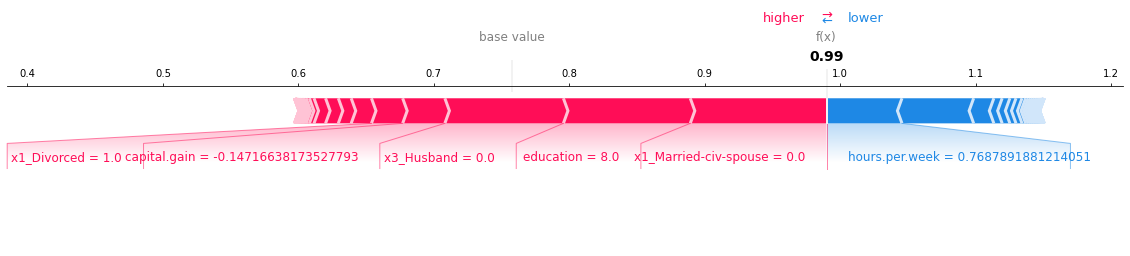

In [37]:
shap.force_plot(
    explainer.expected_value[0],
    shap_values[0][11, :],
    X_train_sample.iloc[11, :],
    matplotlib=True,
)

Observations: 

- Everything is with respect to class 0 here. 
- The base value for class 0 is 0.758. 
- The score for class 0 is 0.95 and so the prediction is class 0 (<=50K). 
- We see the forces that drive the prediction. 
- Features that push the prediction to a higher value are shown in red. 
- Features that push the prediction to a lower value are shown in blue.
- For example, higher value for education (lower education) is pushing us towards <=50K income, whereas the categorical feature x2_Exec-managerial=1 is pushing us towards >50K income. 

Note: a nice thing about SHAP values is that the feature importances sum to the prediction:

In [38]:
shap_values[0][11].sum() + explainer.expected_value[0]

0.990000000137823

This is the same as `predict_proba` score for class 0! 

In [39]:
rf.predict_proba(X_train_sample)[11]

array([0.99, 0.01])

If we consider SHAP values for class 1, it'll be flipped. 

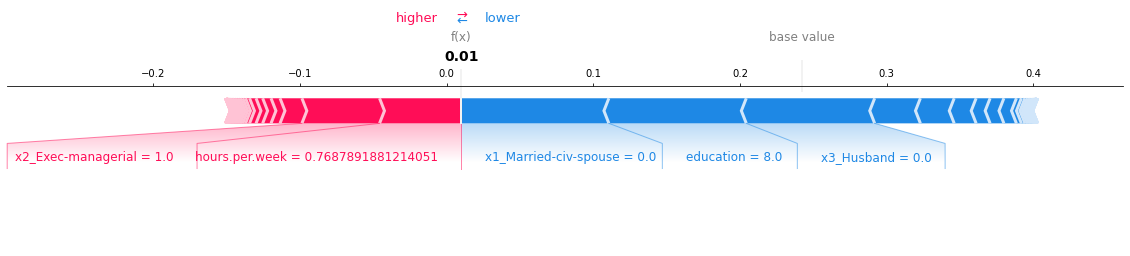

In [40]:
shap.force_plot(
    explainer.expected_value[1],
    shap_values[1][11, :],
    X_train_sample.iloc[11, :],
    matplotlib=True,
)

Above: for this particular training example, we can see the main factors pushing it from the base value (average over the dataset) to this particular prediction. 

Let's try it out on a test example. 
- We first need to get SHAP values for the test example. 
- Let's encode the test data. 

In [41]:
X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test).toarray(),
    columns=feature_names,
    index=X_test.index,
)
X_test_enc.head()

,age,fnlwgt,capital.gain,capital.loss,hours.per.week,education,sex,x0_Federal-gov,x0_Local-gov,x0_Never-worked,...,x4_Puerto-Rico,x4_Scotland,x4_South,x4_Taiwan,x4_Thailand,x4_Trinadad&Tobago,x4_United-States,x4_Vietnam,x4_Yugoslavia,x4_missing
14160,-0.701161,0.864418,-0.147166,-0.21768,-0.042081,12.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
27048,-1.437140,2.379813,-0.147166,-0.21768,-2.069258,12.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
28868,-0.774759,0.141915,-0.147166,-0.21768,-0.042081,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5667,-0.259573,-0.779189,-0.147166,-0.21768,0.363354,6.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7827,-1.363542,-1.291798,-0.147166,-0.21768,-0.852952,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [42]:
X_test_sample = X_test_enc.sample(200, random_state=2)

In [43]:
test_shap_values = explainer.shap_values(X_test_sample)

- What is `predict_proba` output for the first test example? 

In [70]:
rf.predict_proba(X_test_sample)[0]

array([0.92, 0.08])

Let's look at explanation for the prediction of 0.92. 

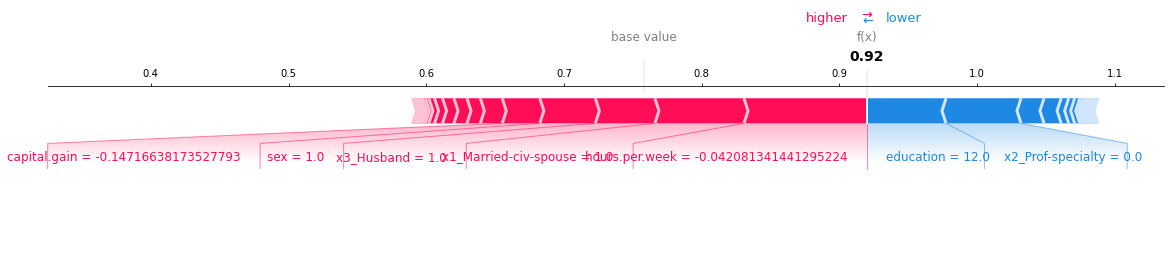

In [45]:
shap.force_plot(
    explainer.expected_value[0],
    test_shap_values[0][0, :],
    X_test_enc.iloc[0, :],
    matplotlib=True,
)

### Summary plot 

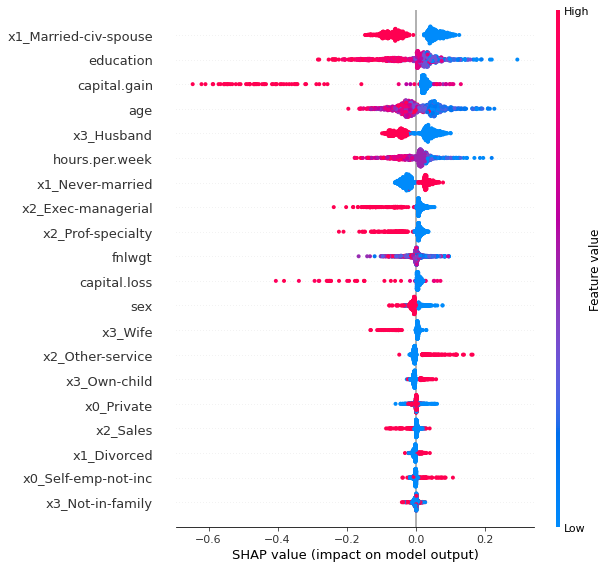

In [46]:
shap.summary_plot(shap_values[0], X_train_sample)

The plot shows the most important features for predicting the class. It also shows the direction of how it's going to drive the prediction.  

- In this case, x1_Married-civ-spouse seems like the most important feature on average.  
- Higher SHAP value means positive association with class 0 (<=50K class) in this case because we are using SHAP values for class 0. 
- Example: Smaller values of age seem to have positive association with class 0. 

### Dependence plot

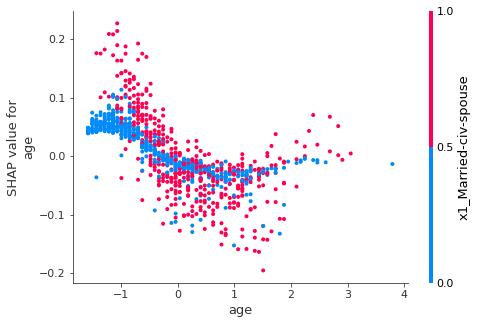

In [47]:
shap.dependence_plot("age", shap_values[0], X_train_sample)

The plot above shows effect of `age` feature on the prediction. 

- Each dot is a single prediction for 1000 examples above.
- The x-axis represents values of the feature age.
- The y-axis is the SHAP value for that feature, which represents how much knowing that feature's value changes the output of the model for that sample's prediction. 
- Lower values of age have higher SHAP values for class "<=50K". 
- The color corresponds to a second feature (x1_Married-civ-spouse feature in this case) that may have an interaction effect with the feature we are plotting. 

Provides explainer for different kinds of models

- [TreeExplainer](https://shap.readthedocs.io/en/latest/) (supports XGBoost, CatBoost, LightGBM) 
- [DeepExplainer](https://shap.readthedocs.io/en/latest/index.html#shap.DeepExplainer) (supports deep-learning models)
- [KernelExplainer](https://shap.readthedocs.io/en/latest/index.html#shap.KernelExplainer) (supports kernel-based models)
- [GradientExplainer](https://shap.readthedocs.io/en/latest/index.html#shap.GradientExplainer) (supports Keras and Tensorflow models)


- Can also be used to explain text classification and image classification 
- Example: In the picture below, red pixels represent positive SHAP values that increase the probability of the class, while blue pixels represent negative SHAP values the reduce the probability of the class. 

<img src="imgs/shap_image_explainer.png" width="600" height="600">

[Source](https://github.com/slundberg/shap)

### Other tools

- [lime](https://github.com/marcotcr/lime) is another package.

If you're not already impressed, keep in mind:

- So far we've only used sklearn models.
- Most sklearn models have some built-in measure of feature importances.
- On many tasks we need to move beyond sklearn, e.g. LightGBM, deep learning.
- These tools work on other models as well, which makes them extremely useful.

#### Why do we want this information?

Possible reasons:

- Identify features that are not useful and maybe remove them.
- Get guidance on what new data to collect.
  - New features related to useful features -> better results.
  - Don't bother collecting useless features -> save resources.
- Help explain why the model is making certain predictions. 
  - Debugging, if the model is behaving strangely.
  - Regulatory requirements.
  - Fairness / bias.
  - Keep in mind this can be use on **deployment** predictions!

## 5. Loss functions


This topic was covered in DSCI 572 last year, which was taught by Mike. 

Below are Mike's notes from last year. 
[Watch Mike's video](https://www.youtube.com/watch?v=OqakHTDV3iI&feature=youtu.be&t=2812) from last year on loss functions. 

(Thanks to Mike for letting me use this material and video in this course!)

In [48]:
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression, LogisticRegression



- You have seen least squares for linear regression:

$$\min_w \sum_{i=1}^n \left(w^Tx_i - y_i\right)^2$$

- (Note: we will use $w$ instead of $\beta$ for the regression coefficients / weights.)
- This function that we're minimizing is called the **loss function**.

#### Example: robust linear regression

- An example of a different loss function would be the absolute value loss:

$$\min_w \sum_{i=1}^n \left| w^Tx_i - y_i \right|$$

- What are the implications of switching between these different choices? 


In [49]:
def lr_loss_squared(w, X, y):
    return np.sum((X @ w - y) ** 2)

In [50]:
def lr_loss_abs(w, X, y):
    return np.sum(np.abs(X @ w - y))

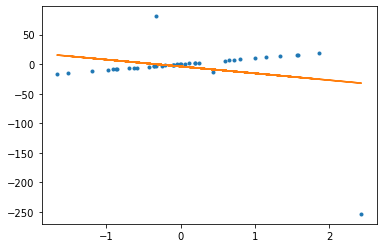

In [51]:
def gen_outlier_data(n=40, Noutliers=3):
    # generate random data
    x = np.random.randn(n)
    y = 10 * x
    # add random outliers
    y[:Noutliers] = -100 * (x[:Noutliers] + np.random.randn(Noutliers))

    X = x[:, None]  # reshape for sklearn

    return X, y


np.random.seed(5)

X, y = gen_outlier_data()
lr = LinearRegression()
lr.fit(X, y)

plt.plot(X, y, ".")
plt.plot(X, lr.predict(X));

In [52]:
X_1 = np.concatenate((X, np.ones(X.shape)), axis=1)

In [53]:
w_min = minimize(lr_loss_squared, np.zeros(2), args=(X_1, y)).x

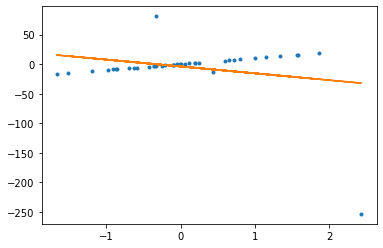

In [54]:
plt.plot(X, y, ".")
plt.plot(X, X_1 @ w_min);

In [55]:
w_min_abs = minimize(
    lr_loss_abs, np.zeros(2), args=(X_1, y)
).x  # don't try this at home

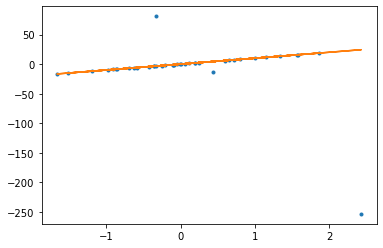

In [56]:
plt.plot(X, y, ".")
plt.plot(X, X_1 @ w_min_abs);

- So, it seems like we got very diffrent fits by changing the loss function.
- In this case, the absolute loss gave us robust regression.
- The loss function is important!

### Aside: an interpretation of the mean and median

- The mean is the number that minimizes the squared loss between itself and the set of numbers.
- The median is the number that minimizes the absolute loss between itself and the set of numbers.

So if you believe the median is more robust than the mean, you should believe the absolute value loss is more robust than the squared loss.

In [57]:
nums = np.array([1, 7, 4, -3, 3.4, 100, 50])

print("Mean of the numbers:", np.mean(nums))
print("Median of the numbers:", np.median(nums))

Mean of the numbers: 23.2
Median of the numbers: 4.0


In [58]:
squared_loss = lambda x: np.sum(np.square(x - nums))
print(
    "Value the minimizes the squared distance from the numbers:",
    minimize(squared_loss, 0).x,
)

Value the minimizes the squared distance from the numbers: [23.19999869]


In [59]:
absolute_loss = lambda x: np.sum(np.abs(x - nums))
print(
    "Value the minimizes the absolute value distance from the numbers:",
    minimize(absolute_loss, 0).x,
)

Value the minimizes the absolute value distance from the numbers: [3.99999999]


### Back to the big picture

We can start to think of (a lot of) ML as a 3-step process:

1. Choose your model
2. Choose your loss function
3. Choose your optimization algorithm

What do these do?

1. The model controls the space of possible functions from $X$ to $y$.
  - For example, a linear model can only learn linear functions.
2. The loss function tells us how to compare these various functions.
  - For example, is $y=2x_1+3x_2$ a better model than $y=10x_1-x_2$?
3. The optimization algorithm computationally finds the minimum of the loss function.
  - You will learn about this in DSCI 572. 

#### Loss function example: logistic regression vs. SVM

In [60]:
n = 100
d = 2

X = np.random.rand(n, d)
y = np.random.choice((-1, +1), size=n, replace=True)
X[y == 1, 0] += 0.5

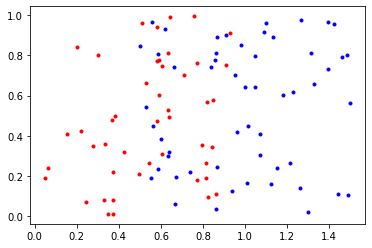

In [61]:
plt.plot(X[y == -1, 0], X[y == -1, 1], ".r")
plt.plot(X[y == 1, 0], X[y == 1, 1], ".b");

In [62]:
y = y[:, None]

In [63]:
def plot_loss_2d(loss_fun, title="", nw1=100, nw2=100):
    wmin = -5
    wmax = 5
    w1_lin = np.linspace(wmin, wmax, nw1)
    w2_lin = np.linspace(wmin, wmax, nw2)
    w1_grid, w2_grid = np.meshgrid(w1_lin, w2_lin)

    w1_flat = w1_grid.flatten()
    w2_flat = w2_grid.flatten()

    W = np.concatenate((w1_flat[None], w2_flat[None]), axis=0)

    loss_flat = loss_fun(W, X, y)
    loss_grid = np.reshape(loss_flat, (nw1, nw2))

    #     plt.imshow(loss_grid, extent=(np.min(w1_lin), np.max(w1_lin), np.min(w2_lin), np.max(w2_lin)), origin='lower')
    CS = plt.contour(w1_grid, w2_grid, loss_grid, levels=20)

    imin = np.argmin(loss_grid)
    plt.plot(w1_flat[imin], w2_flat[imin], "r*", markersize=15)

    plt.xlabel("$w_1$")
    plt.ylabel("$w_2$")
    plt.title(title)


#     plt.colorbar();

- Logistic regression are both linear classifiers, but they use different loss functions.
- You saw in DSCI 571 that these differences have some implications, like the idea of "support vectors".
- We can visulalize these loss functions below:

In [64]:
def loss_lr(w, X, y, λ=1e-3):
    return np.sum(np.log(1 + np.exp(-y * (X @ w))), axis=0) + λ * np.sum(w ** 2, axis=0)


def loss_svm(w, X, y, λ=1e-3):
    return np.sum(np.maximum(0, 1 - y * (X @ w)), axis=0) + λ * np.sum(w ** 2, axis=0)

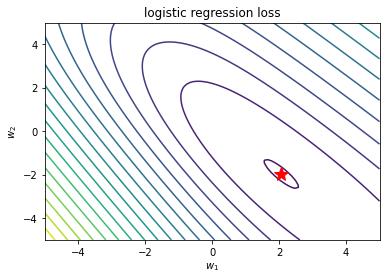

In [65]:
plot_loss_2d(loss_lr, "logistic regression loss")

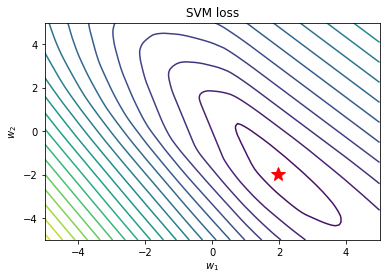

In [66]:
plot_loss_2d(loss_svm, "SVM loss")

- In practice, we need to use different methods to minimize these functions, because the SVM loss is non-smooth.
- However, that is beyond the scope of the course.
- We can see more of the non-smoothness below if we take a vertical slice of these 2d contour plots.

In [67]:
def plot_loss_1d(loss_fun, title="", w1=0):
    w2_grid = np.linspace(-5, 5, 5000)
    w = np.zeros((2, len(w2_grid)))
    w[1] = w2_grid  # vary w2
    w[0] = w1
    loss_slice = loss_fun(w, X, y)
    plt.plot(w2_grid, loss_slice)
    plt.xlabel("$w_2$")
    plt.ylabel("loss")
    plt.title(title);

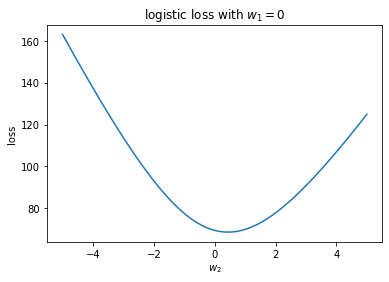

In [68]:
plot_loss_1d(loss_lr, "logistic loss with $w_1=0$")

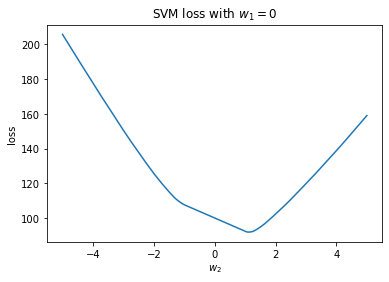

In [69]:
plot_loss_1d(loss_svm, "SVM loss with $w_1=0$");

### True/False questions for class discussion

1. You train a random forest on a binary classification problem with two classes [neg, pos]. A value of 0.580 for feat1 given by `feature_importances_` attribute of your model means that increasing the value of feat1 will drive us towards positive class. (False)
2. eli5 can be used to get feature importances for non `sklearn` models. (True)
3. With SHAP you can only explain predictions on the training examples. (False)
4. When you add up the shapely values for an example and the expected value, you get the same score as `predict_proba` output. (False. Not for all models. For random forests you do get `predict_proba` scores but for light GBMs you don't.)